## How to run the lstchain_dl1ab.py script (example using Monte Carlo)


<br>
First check the help of the script:

```
lstchain_dl1ab -h

usage: lstchain_dl1ab.py [-h] --input-file INPUT_FILE --output-file
                         OUTPUT_FILE [--config CONFIG_FILE]
                         [--no-image NOIMAGE]
                         [--pedestal-cleaning PEDESTAL_CLEANING]

Recompute DL1b parameters from a DL1a file

optional arguments:
  -h, --help            show this help message and exit
  --input-file INPUT_FILE, -f INPUT_FILE
                        path to the DL1a file
  --output-file OUTPUT_FILE, -o OUTPUT_FILE
                        key for the table of new parameters
  --config CONFIG_FILE, -c CONFIG_FILE
                        Path to a configuration file. If none is given, a
                        standard configuration is applied
  --no-image NOIMAGE    Boolean. True to remove the images in output file
  --pedestal-cleaning PEDESTAL_CLEANING
                        Boolean. True to use pedestal cleaning
```

#### Notes:
- the script __will not overwrite an existing file__. In lstchain 0.8.4 it will crash if the file exists. This has already been fixed in the lstchain master (i.e. it now exists with a proper error message)
- the script recalculates image parameters (DL1b) using calibrated images (DL1a) found in the input file, and applying whatever image cleaning settings are provided through the configuration file. Therefore the input file must contain the DL1a information, that is, the "images" table.
- when the `--no-image` option is set to True the output file contains only image parameters and no pixel-wise information. Otherwise, the "images" table of the input file is copied to the output file, except in case the image_modifier option is activated via the config file (see below).
- the `pedestal-cleaning` option (set to false by default) is only for processing real data. It increases the picture cleaning threshold for noisy pixels (e.g. those illuminated by stars) to avoid spurious signals.


#### Suggested input file (point-like gammas, 0.4 deg wobble offset):

`/fefs/aswg/workspace/analysis-school-2022/DL1ab/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5`

If no configuration file is given, the standard lstchain configuration file lstchain_standard_config.json is used. 

For the test you can use the example configuration file<br>
`analysis-school-2022/DL1ab/config/lstchain_dl1ab_tune_MC_to_Crab_config.json` (see below). 

Under "tailcut" and "dynamic cleaning" you can set the parameters for the image cleaning. The "image_modifier" section is discussed below.

```
{
  "image_modifier": {
    "increase_nsb": true,
    "extra_noise_in_dim_pixels": 1.2,
    "extra_bias_in_dim_pixels": 0.5,
    "transition_charge": 8,
    "extra_noise_in_bright_pixels": 1.2,
    "increase_psf": true,
    "smeared_light_fraction": 0.125
  },

  "tailcut": {
    "picture_thresh":8,
    "boundary_thresh":4,
    "keep_isolated_pixels":false,
    "min_number_picture_neighbors":2,
    "use_only_main_island":false,
    "delta_time": 2
  },

  "dynamic_cleaning": {
    "apply": true,
    "threshold": 267,
    "fraction_cleaning_intensity": 0.03
  }
}

```

#### image__modifier settings:
These are intended for fine-tuning MC simulations to a given set of real data, in terms of the diffuse NSB noise level in the pixels, and of the optical point-spread function of the telescope. In this way we can adapt a given MC set to different observations, without having to re-simulate the events, or even re-calibrate them. The settings in the json file above tune our current MC to observations of the Crab nebula **. We recommend to leave those settings unchanged for the test.

Whenever increase_psf and/or increase_nsb are true, the images are modified before the cleaning step (by adding random noise to each pixel, and/or spreading the charge to simulate a worse PSF). Currently any of these two options automatically __switches off__ the saving of the DL1a ("images" table) to the output of `lstchain_dl1ab.py`
<br>
<br>
** The NSB settings for a different field can be obtained with the script `lstchain_tune_nsb.py`, but that is not part of this exercise; the production of the adequate MC for each set of real data will eventually be automatized.

#### Example of lstchain_dl1ab.py call (assuming you are in the desired output directory and you have the json file there as well):

Normally you would run lstchain_dl1ab from a terminal (or if you are in the IT cluster, submitting it in a script as a slurm job). For the example we will launch it from the notebook:

In [20]:
# Directory where you downloaded the school's dataset. By default is in ... 2022_01_lstchain_school/data
SCHOOL_DATASET = "../data"

# Directory where we want to get the lstchain_dl1ab output (bt default it
# will be ... 2022_01_lstchain_school/output_DL1ab:
OUTPUT_DIRECTORY = "../output_DL1ab"

# create (if needed) the directory:
!mkdir -p {OUTPUT_DIRECTORY}

# Name of the output file name. Make sure no file with that name exists in the output directory.
OUTPUT_FILENAME = "gamma_dl1.h5"

In [22]:
!lstchain_dl1ab \
-f {SCHOOL_DATASET}/DL1ab/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5 \
-o {OUTPUT_DIRECTORY}/{OUTPUT_FILENAME} \
-c {SCHOOL_DATASET}/DL1ab/config/lstchain_dl1ab_tune_MC_to_Crab_config.json

image_modifier configuration: {'increase_nsb': True, 'extra_noise_in_dim_pixels': 1.2, 'extra_bias_in_dim_pixels': 0.5, 'transition_charge': 8, 'extra_noise_in_bright_pixels': 1.2, 'increase_psf': True, 'smeared_light_fraction': 0.125}
NOTE: Using the image_modifier options means images will not be saved.
Tailcut config used: {'picture_thresh': 8, 'boundary_thresh': 4, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
/Users/moralejo/opt/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'readout_LSTCam.__table_column_meta__'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr(

In the output above you can see some text reporting the cleaning and other settings. Then a number of harmless warnings ("...NaturalNameWarning", which are already silenced in the current lstchain master). 

You may want to play with the cleaning settings and compare the output image parameters (width, length...). The rest of the notebook explains how to access the DL1b data in the DL1 files.

In [23]:
import glob

from ctapipe.io import read_table
from ctapipe.instrument import SubarrayDescription
from ctapipe.visualization import CameraDisplay

from astropy.table import vstack, Table
from lstchain.io.io import dl1_params_lstcam_key
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u

%matplotlib inline

## Accessing the contents of the DL1 files

In [24]:
dl1_file = OUTPUT_DIRECTORY+"/"+OUTPUT_FILENAME

In [25]:
# Read parameters table from file:
print(dl1_params_lstcam_key)
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)

/dl1/event/telescope/parameters/LST_LSTCam


In [26]:
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,TeV,,rad,rad,m,m,m,,rad,rad,g / cm2,m,,,m,m,m,,,,,,,,,,
int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float64,int64,float32,float32,float32,float32,float32,float32,float32
10,203,956.2705058097838,2.980580761065781,0.3778537023286246,0.27035541557380677,0.464613248943177,0.6210549890203959,0.251741202131799,0.0041422241177132176,0.06389738699028609,0.0017757381130520796,1.0402191523426867,0.30376413851055445,2.03560406641402,-0.21777019168748346,13.642939654975102,0.0,0.0,0.0,0.0,33,0.2258250791579407,0.4228140592830671,0.10427681981529088,1,1.2147492,3.1415927,-1,0.15828366577625275,-0.8005639002308581,1.2217304706573486,3.1415927410125732,8.300270080566406,35.978363037109375,32226.966796875,0,3.1415927,1.2147492,211.7142791748047,118.44808958008554,0.2538202001301083,1,-70.93,-52.07,43.0,32,1606641878.637238,32,-0.18237738,-0.2703554,0.32611895,0.97733265,-1.0,0.19547632,2.4369417e-12
10,305,160.08864378929138,2.204360525457273,0.3609242611867041,0.34664956253345514,0.5004320548464137,0.7652267522107595,0.09759148470102182,0.004471430620175338,0.047764317460353076,0.0018100605743326084,0.8126961288932595,0.16314442835073667,2.344277164604059,16.084332412587113,12.169130368637266,0.0,0.0,0.0,0.0,10,0.541221118166278,0.457654420947948,0.22998363899142535,1,1.2147492,3.1415927,-1,0.019269723445177078,-1.715124518198486,1.2217304706573486,3.1415927410125732,-3.2260520458221436,65.57146453857422,13098.6416015625,0,3.1415927,1.2147492,300.0,135.73260005202582,0.48943083999700593,1,-70.93,-52.07,43.0,32,1606641881.287831,32,-0.16544794,-0.34664956,0.38410798,1.1254916,-1.0,0.19547632,2.4369417e-12
10,807,71.45917730331419,1.8540580119407615,0.2921325772099768,0.1166685926804358,0.31456796274474064,0.3799619905198027,0.056832982940266646,0.0050789841921628906,0.05211547982459548,0.0044150875958263594,-1.1406928268485077,1.1753156686105541,3.282814070991259,-0.46258034401131454,11.642476669858127,0.0,0.0,0.0,0.0,6,0.7005098344739039,0.4913780716892498,0.4913780716892498,1,1.2147492,3.1415927,-1,0.02786845527589321,-1.5548871031829294,1.2217304706573486,3.1415927410125732,5.178720474243164,37.719139099121094,25513.671875,0,3.1415927,1.2147492,173.3333282470703,117.70567880963914,0.9169935204631274,1,-70.93,-52.07,43.0,32,1606641883.221573,32,-0.096656255,-0.11666859,0.15150575,0.878936,-1.0,0.19547632,2.4369417e-12
10,1305,105.43016910552979,2.0229649031085226,0.1349632359818215,-0.7800266678356782,0.7916164965445808,-1.399468706930374,0.11246960184063215,0.005981957541930029,0.06124717910579814,0.004393975293057896,1.535583266762247,0.19165165902391823,2.1929991082837463,-19.405070368634565,12.815230264064086,0.0,0.0,0.0,0.0,10,0.49274076811861833,0.4348737450932957,0.15413272424189098,1,1.2147492,3.1415927,-1,0.4249720871448517,-0.3716395941780785,1.2217304706573486,3.1415927410125732,-89.23172760009766,-393.1084899902344,29089.869140625,0,3.1415927,1.2147492,211.81817626953125,341.5292155657408,0.5445660228690024,1,-70.93,-52.07,43.0,32,1606641886.153733,32,0.06051308

Description of parameters in\
https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

Notes: 
- these DL1 files are provisional and LST-specific. Eventually we will use the agreed DL1 model already implemented in ctapipe:\
    https://cta-observatory.github.io/ctapipe/data_models/dl1.html#dl1-data-model


- the table contains nans for parameters which could not be calculated for whatever reason (e.g. no pixels survived cleaning)


- parameters like coordinates and angles are in the standard camera frame, ctapipe.coordinates.CameraFrame. Below we will show how to transform them to the more commonly used EngineeringCameraFrame (which is how we would see the camera with the telescope in parking position)


- there are some parameters which do not change event-wise, yet they are written in the events table for convenience (tel_id, tel_pos_x, tel_pos_y, tel_pos_z)


- there is also redundant information: in MC files mc_alt_tel, mc_az_tel are identical to alt_tel, az_tel. Energy (in MC) and intensity appear also in logarithmic form.


- mc_type (primary type, in eventio convention): 0 (gamma), 1(e-), 2(mu-), 100*A+Z for nucleons and nuclei, negative for antimatter


- Some parameters don't have their units in the table (if not mentioned below, they are adimensional):
 - intensity: photoelectrons  (log_intensity is just log10 of that)
 - intercept: ns (it is the fitted time value at the image charge COG)
 - time_gradient: ns / deg (slope of the linear time fit along the majior image axis)
 - trigger_time is a unix time in seconds - for simulations it is just the event sim_telarray simulation time, so it has no physical meaning.

 Only for MC:
 - src_x src_y: meters. True event direction on the camera. 
 - disp_dx, disp_dy, disp_norm: meters. Note: these are __*not*__ reconstructed values, but true ones (calculated with the true event direction) for the purpose of training the direction reconstruction. With the x, y in the table being the coordinates of the image center of gravity, disp_dx = src_x - x, and disp_dy = src_y - y 
 - disp_angle: radians (-pi/2 to pi/2). It is equal to tan(disp_dy/disp_dx)



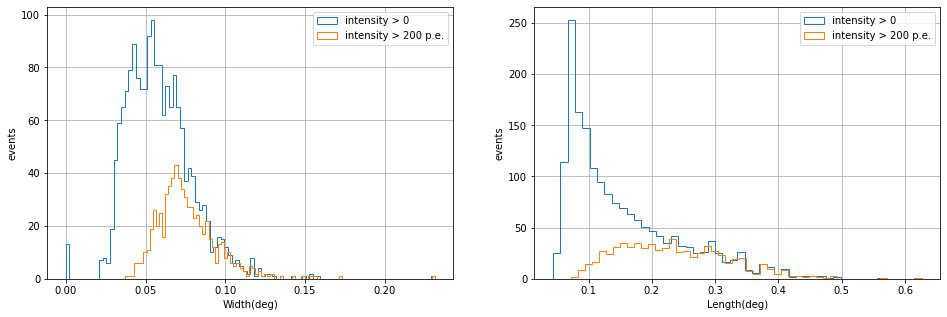

In [27]:
# Example plots: width and length distributions

intensity_cut = dl1_parameters['intensity'] > 200
fig = plt.figure(figsize=(16,5))

fig.add_subplot(1, 2, 1)
# Width distribution for all events:
plt.hist(dl1_parameters['width'], bins=100, histtype='step', label='intensity > 0')
# Now for higher intensities only:
intensity_cut = dl1_parameters['intensity'] > 200
plt.hist(dl1_parameters['width'][intensity_cut], bins=100, histtype='step', label='intensity > 200 p.e.')
plt.grid()
plt.xlabel('Width(deg)')
plt.ylabel('events')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.hist(dl1_parameters['length'], bins=50, histtype='step', label='intensity > 0')
plt.hist(dl1_parameters['length'][intensity_cut], bins=50, histtype='step', label='intensity > 200 p.e.')
plt.grid()
plt.xlabel('Length(deg)')
plt.ylabel('events')
plt.legend()


plt.show()

In [28]:
np.nanmax(dl1_parameters['disp_angle'])

1.569458

### Loading more than one DL1 file in a single table

Note: this is for execution as a remote notebook in La Palma, since it has to access ~40 DL1 files that are pretty bulky. If you want to execute it at home with the school's sample, just change the input files to the single DL1 in the sample (see below)

In [29]:
# If you need to work with more statistics, you can create a table with many input files.
# glob allows to use wildcards. Example with DL1 MC gamma files produced with lstchain 0.7 (if you are running
# in the IT cluster):

# dl1_files = glob.glob("/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/gamma/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/off0.4deg/testing/dl1_gamma_20deg_180deg_run??___*.h5") 

# Example proton files:
# dl1_files = glob.glob("/fefs/aswg/data/mc/DL1/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/testing/dl1_proton_20deg_180deg_run1??___*.h5") 

# If you are running at home, using the school's dataset, you can use the same file as before:
dl1_files = glob.glob(OUTPUT_DIRECTORY+"/"+OUTPUT_FILENAME)

In [30]:
dl1_files.sort()

# Create empty table for DL1 parameters ()
dl1_parameters = Table()

for file in dl1_files:
    dl1_parameters = vstack([dl1_parameters,
                             read_table(file, dl1_params_lstcam_key)])
print('Number of events:', len(dl1_parameters))

Number of events: 2149


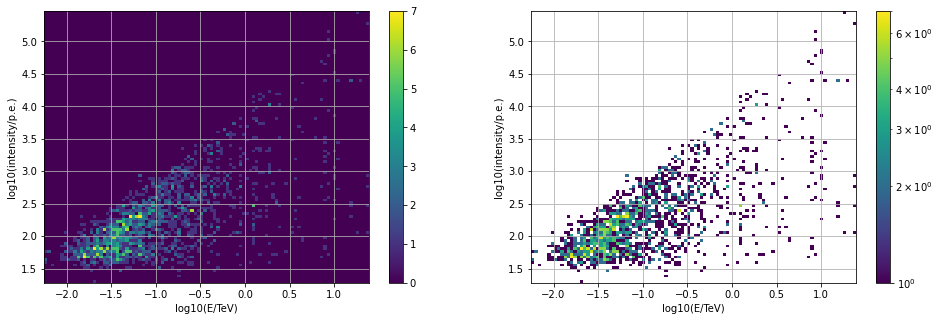

In [31]:
# Simple example plot. Correlation between image intensity and primary energy.

mask = dl1_parameters['intensity'] > 0  # successfully cleaned & parametrized images

fig = plt.figure(figsize=(16,5))
fig.add_subplot(1, 2, 1)
plt.hist2d(dl1_parameters['log_mc_energy'][mask], 
           np.log10(dl1_parameters['intensity'][mask]), bins=(100,100))
plt.xlabel('log10(E/TeV)')
plt.ylabel('log10(intensity/p.e.)')
plt.grid()
plt.colorbar()

fig.add_subplot(1, 2, 2)
# The same in logarithmic z-scale:
plt.hist2d(dl1_parameters['log_mc_energy'][mask], 
           np.log10(dl1_parameters['intensity'][mask]), bins=(100,100), norm=LogNorm())
plt.xlabel('log10(E/TeV)')
plt.ylabel('log10(intensity/p.e.)')
plt.grid()
plt.colorbar()

plt.show()


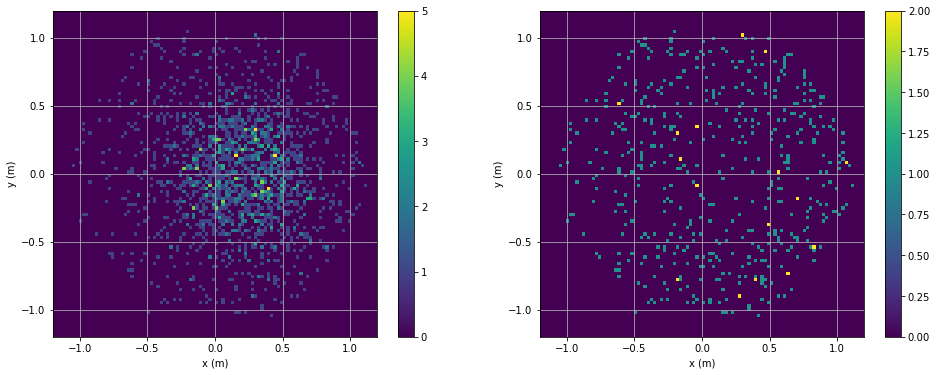

In [32]:
# Some example plots:
# (Note that by setting the range of the axes you don't have to explicitly cut out nans)

fig = plt.figure(figsize=(16,6))

fig.add_subplot(1, 2, 1)
# Plot distribution of image CoG:
plt.hist2d(dl1_parameters['x'], dl1_parameters['y'], 
           bins=(100,100), range = ((-1.2, 1.2),(-1.2, 1.2)))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.colorbar()

fig.add_subplot(1, 2, 2)
# The same, for events with energy above 200 GeV
mask = dl1_parameters['mc_energy'] > 0.2 * u.TeV
plt.hist2d(dl1_parameters['x'][mask], dl1_parameters['y'][mask], 
           bins=(100,100), range = ((-1.2, 1.2),(-1.2, 1.2)))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.colorbar()

plt.show()


The distribution of events is shifted w.r.t. the camera center (0, 0) because the gamma rays arrive 0.4 degrees off-axis. This corresponds more or less to 0.2 meters:

In [33]:
subarray_info = SubarrayDescription.from_hdf(dl1_files[0]) # Read instrument description from first file
np.tan(0.4*u.deg) * subarray_info.tel[1].optics.equivalent_focal_length # 1 stands for LST-1 in this MC

<Quantity 0.19548005 m>

The distribution of CoGs is related to the shape of the Cherenov light pool (hence the ring-shaped of the plot on the left). At higher energies the showers manage to trigger the telescope well beyond the inner light pool (where light density is roughly uniform) and hence the distribution of CoGs becomes less concentrated.

Note that the x, y coordinates in the DL1b parameters table are __in the default camera system ctapipe.coordinates.CameraFrame__, different from the EngineeringCameraFrame which shows the camera "how we would see it" in parking position. Hence the hexagon orientation.

## Suggested additional exercises

The psi angle in the parameters table (-pi/2 to pi/2) is the angle between the x-axis and the image axis

disp_angle (-pi/2 to pi/2) is the angle between the x-axis and the line from the cog (x, y) to the true event direction (src_x, src_y).
From their difference we can obtain the "Alpha" angle, indicating how well the image axis aligns with the true direction of the event (note that this is not the most general way to calculate Alpha! In real data DL1 files we do
not have "disp_angle" since the true event direction is not known - one can of course calculate it w.r.t. a given source position)

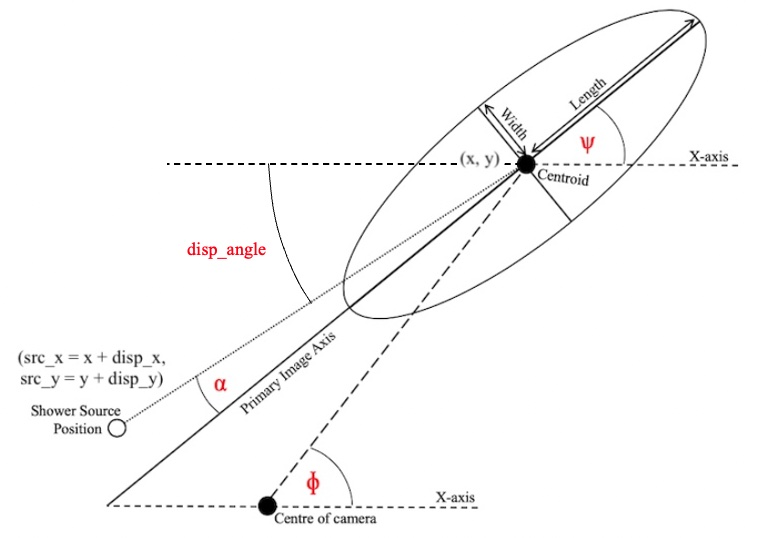

Below we calculate its value and plot its distribution for events dimmer and brighter than a given value. Brighter images have better defined axes, hence (for gammas) better aligned with the true event direction (smaller Alpha).

You can run the lstchain_dl1ab script with different cleaning settings (e.g. with very low cleaning thresholds like 4 and 2 p.e.) and see how this affects the Alpha distribution and other image parameters.

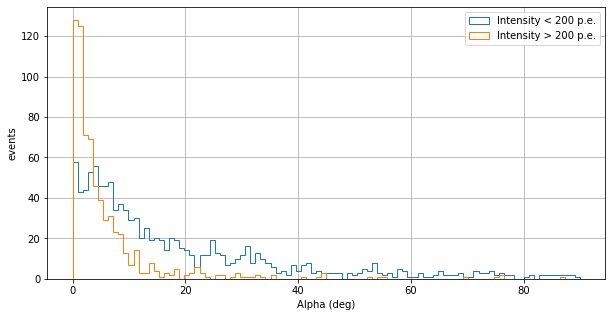

In [34]:
# Calculate alpha in degrees:
alpha_0_to_180 = np.rad2deg(abs(dl1_parameters['psi']-dl1_parameters['disp_angle']))

# convert to 0-90 degrees range:
alpha_0_to_90 = np.where(alpha_0_to_180<90, alpha_0_to_180, 180-alpha_0_to_180)

plt.figure(figsize=(10,5))

intensity_cut = 200
mask = dl1_parameters['intensity'] < intensity_cut
plt.hist(alpha_0_to_90[mask], bins=100, range=(0, 90), histtype='step', label=f'Intensity < {intensity_cut} p.e.')

plt.hist(alpha_0_to_90[~mask], bins=100, range=(0, 90), histtype='step', label=f'Intensity > {intensity_cut} p.e.')

plt.xlabel('Alpha (deg)')
plt.ylabel('events')
plt.legend()
plt.grid()
plt.show()
